In [1]:
import os, sys
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from category_encoders import OneHotEncoder
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning or RuntimeWarning)

c:\Python39\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
df = pd.read_parquet("../../data/after_light_prepro_Oct_Nov.parquet.gzip",
columns = ['event_type_view', 'event_type_purchase', 'category_code', 'price', 'hour', 'category_code_0'])

## Action Plan 도출
* 1) 상시 마케팅
* 2) 타임세일형 마케팅

### 1. 상시마케팅

#### 1.1 첫번째 Category별 매출 비중(top5 이외 etc)

In [4]:
def Category_0_sales(df) :
    df = df[df['category_code_0'] != 'missing']
    df = df[df["event_type_purchase"] > 0].groupby(["category_code_0"], as_index= False).sum().sort_values('price', ascending=False)

    category1_sales = df[['category_code_0', 'price']]
    category1_sales_top5 = category1_sales[0:5]
    category1_sales_etc = category1_sales[6:]
    category1_sales_etc['category_code_0'] = category1_sales_etc['category_code_0'].apply(lambda x : 'etc')
    category1_sales_etc = category1_sales_etc.groupby(['category_code_0']).sum().reset_index()

    category1_sales = pd.concat([category1_sales_top5, category1_sales_etc]).sort_values(by=['price'], ascending=False)

    return category1_sales


In [5]:
df_category1_sales = Category_0_sales(df)
df_category1_sales

C:\Users\havea\AppData\Local\Temp/ipykernel_8620/644382333.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category1_sales_etc['category_code_0'] = category1_sales_etc['category_code_0'].apply(lambda x : 'etc')


,category_code_0,price
7,electronics,3.817143e+08
2,appliances,3.222362e+07
4,computers,2.537321e+07
8,furniture,4.216980e+06
0,etc,4.156431e+06
3,auto,2.649036e+06


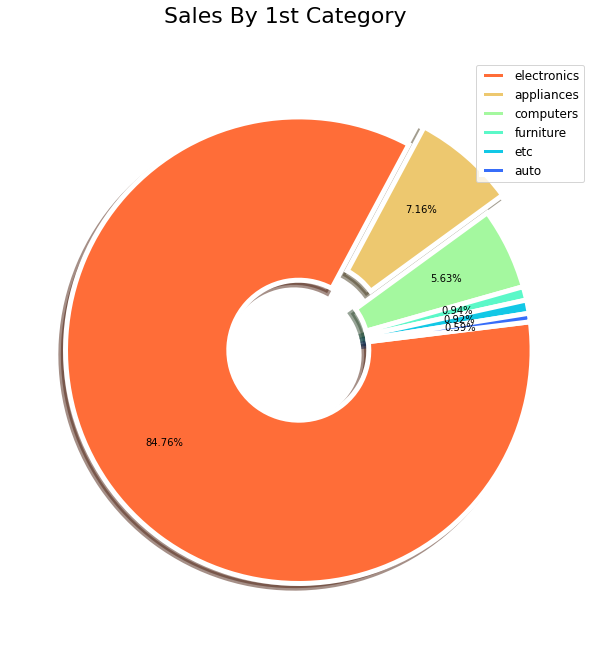

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
fig.suptitle('Sales By 1st Category', fontsize=22)
fig.subplots_adjust(left=0.125, bottom=0., right=0.9, top=0.9, wspace=0.2, hspace=0.4)
sns.axes_style(style='darkgrid')

# 들어갈 라벨
labels=df_category1_sales['category_code_0']

# 특수한 파이를 돌출
explode = [0,0.1, 0, 0, 0, 0]

# 색설정 및 몇개 색이 필요한지 len값으로 설정
colors = sns.color_palette('rainbow_r',len(df_category1_sales['category_code_0']))

# 하얀색 테두리 그리기
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

# price에 대한 파이나누기(소숫점 둘째점까지 표현)
plt.pie(df_category1_sales['price'], autopct = "%1.2f%%", pctdistance=0.7,
startangle=7, counterclock=False, explode=explode, shadow=True, colors=colors, wedgeprops=wedgeprops)
plt.legend(labels, fontsize = 12, loc = 'upper right')
plt.show()

del df_category1_sales

#### 1.2 Electronics 세부카테고리별 매출 비중 (Top5 이외 etc)


In [7]:
def elec_sales(df = df) :
    df = df[df['category_code_0'] == 'electronics'][['event_type_view', 'event_type_purchase', 'category_code', 'price']]
    df = df[df['event_type_purchase'] == 1].groupby(['category_code']).sum().reset_index()[['category_code', 'price']]
    df = df.sort_values('price', ascending=False)

    elec_sales_top5 = df[0:5]
    elec_sales_etc = df[6:]
    elec_sales_etc['category_code'] = elec_sales_etc['category_code'].apply(lambda x : 'etc')
    elec_sales_etc = elec_sales_etc.groupby(['category_code']).sum().reset_index()

    df = pd.concat([elec_sales_top5, elec_sales_etc]).sort_values(by=['price'], ascending=False)

    return df

In [8]:
df_elec = elec_sales()
df_elec

C:\Users\havea\AppData\Local\Temp/ipykernel_8620/1928569566.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_sales_etc['category_code'] = elec_sales_etc['category_code'].apply(lambda x : 'etc')


,category_code,price
8,electronics.smartphone,3.348713e+08
12,electronics.video.tv,2.088056e+07
7,electronics.clocks,1.137104e+07
1,electronics.audio.headphone,9.208629e+06
9,electronics.tablet,3.131227e+06
0,etc,1.644327e+06


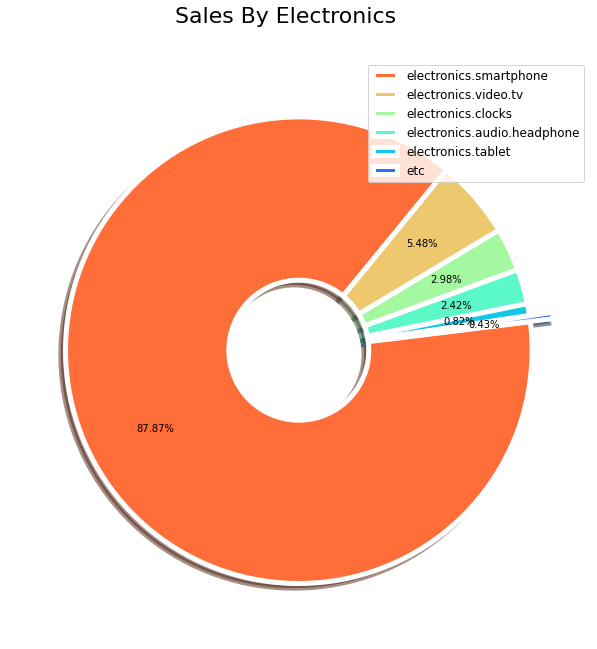

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
fig.suptitle('Sales By Electronics', fontsize=22)
fig.subplots_adjust(left=0.125, bottom=0., right=0.9, top=0.9, wspace=0.2, hspace=0.4)
sns.axes_style(style='darkgrid')

# 들어갈 라벨
labels=df_elec['category_code']

# 특수한 파이를 돌출
explode = [0, 0, 0, 0, 0, 0.1]

# 색설정 및 몇개 색이 필요한지 len값으로 설정
colors = sns.color_palette('rainbow_r',len(df_elec['category_code']))

# 하얀색 테두리 그리기
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

# price에 대한 파이나누기(소숫점 둘째점까지 표현)
plt.pie(df_elec['price'], autopct = "%1.2f%%", pctdistance=0.7,
startangle=7, counterclock=False, explode=explode, shadow=True, colors=colors, wedgeprops=wedgeprops)
plt.legend(labels, fontsize = 12, loc = 'upper right')
plt.show()

del df_elec

#### 1.3 Electronics 세부카테고리별 매출 대비 전환율

In [10]:
def elec_CVR(df = df) :
    df = df[df['category_code_0'] == 'electronics'][['event_type_view', 'event_type_purchase', 'category_code', 'price']]
    df = df[['category_code', 'event_type_view', 'event_type_purchase']].groupby(['category_code']).sum().reset_index()[['category_code','event_type_view', 'event_type_purchase']]
    df['CVR(%)'] = df['event_type_purchase'] / df['event_type_view'] * 100
    df = df[['category_code', 'CVR(%)']]
    df = df.sort_values('CVR(%)', ascending=False).reset_index(drop = True)

    return df

In [11]:
df_elec_cvr = elec_CVR()
df_elec_cvr

,category_code,CVR(%)
0,electronics.smartphone,2.831485
1,electronics.audio.headphone,2.678366
2,electronics.video.tv,1.657646
3,electronics.tablet,1.532638
4,electronics.telephone,1.426407
5,electronics.camera.photo,1.278178
6,electronics.clocks,1.259265
7,electronics.audio.microphone,1.258232
8,electronics.audio.music_tools.piano,1.168400
9,electronics.audio.subwoofer,1.051700


In [12]:
def elec_CVR_sort(df = df_elec_cvr) :
    
    sales_top = [1,5,7,9,10]
    sales = df.index.values.tolist()
    diff = list(set(sales).difference(sales_top))

    elec_cvr_top5 = df[df.index.isin(sales_top)].sort_values(by=['CVR(%)'], ascending=False)
    elec_cvr_etc = df[df.index.isin(diff)]
    elec_cvr_etc['category_code'] = elec_cvr_etc['category_code'].apply(lambda x : 'etc')
    elec_cvr_etc = elec_cvr_etc.groupby(['category_code']).sum().reset_index()

    df = pd.concat([elec_cvr_top5, elec_cvr_etc])
    return df

In [13]:
df_elec_cvr_sort = elec_CVR_sort()

C:\Users\havea\AppData\Local\Temp/ipykernel_8620/1210603477.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_cvr_etc['category_code'] = elec_cvr_etc['category_code'].apply(lambda x : 'etc')


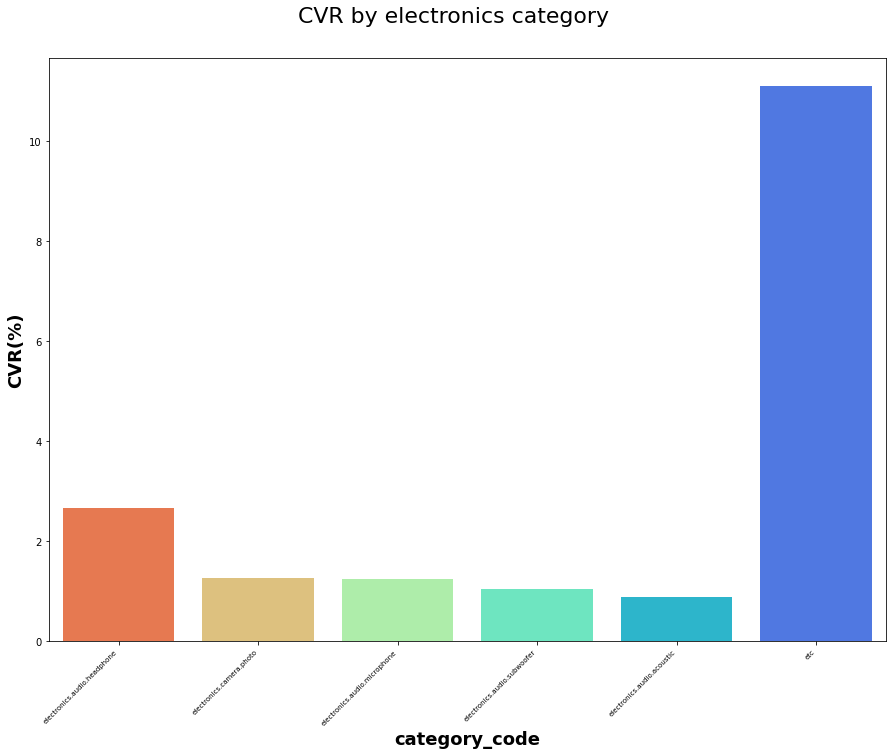

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
fig.suptitle('CVR by electronics category', fontsize=22)
fig.subplots_adjust(left=0.125, bottom=0., right=0.9, top=0.9, wspace=0.2, hspace=0.4)
sns.axes_style(style='darkgrid')

CVR_bar = sns.barplot(x='category_code', y= 'CVR(%)', data=df_elec_cvr_sort, palette='rainbow_r')
# CVR_bar.set(font_scale=1.8)
CVR_bar.set_xticklabels(CVR_bar.get_xticklabels(), rotation=45,
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-small'
                 )

plt.xlabel('category_code', fontsize = 18, fontweight = 'bold')
plt.ylabel('CVR(%)', fontsize = 18, fontweight = 'bold')
plt.show

del df_elec_cvr
del df_elec_cvr_sort

### 2. 타임세일형 마케팅

##### 2.1 Afternoon 시간대

In [3]:
def to_hour_category(hour, time_split):
    if (hour >= time_split[0]) and (hour < time_split[1]):
        return 1
    elif (hour >= time_split[1]) and (hour < time_split[2]):
        return 2
    elif (hour >= time_split[2]) and (hour < time_split[3]):
        return 3
    else:
        return 0

In [4]:
def df_to_time(df=df):
    df["hour"] = df["hour"].apply(to_hour_category, args=([4,12,19,22],))
    temp_dict = {1 : "morning", 2 : "afternoon", 3 : "evening", 0 : "bedtime"}
    df["hour"] = df["hour"].apply(lambda x : temp_dict[x])

    return df

In [5]:
df_time = df_to_time()
del df

In [7]:
def timezone_afternoon(df = df_time) : 
    df = df[df['category_code_0'] != 'missing']
    df = df[df['hour'] == 'afternoon'][['event_type_view', 'event_type_purchase', 'category_code', 'price']]

    df_sale = df[df['event_type_purchase'] == 1].groupby(['category_code']).sum().reset_index()[['category_code', 'price']]
    df_sale = df_sale.sort_values('price', ascending=False)

    df_sale_top5 = df_sale[0:5]
    df_sale_etc = df_sale[6:]
    df_sale_etc['category_code'] = df_sale_etc['category_code'].apply(lambda x : 'etc')
    df_sale_etc = df_sale_etc.groupby(['category_code']).sum().reset_index()

    df = pd.concat([df_sale_top5, df_sale_etc]).sort_values(by=['price'], ascending=False).reset_index(drop = True)

    return df

In [19]:
df_afternoon = timezone_afternoon()
df_afternoon

C:\Users\havea\AppData\Local\Temp/ipykernel_8620/978306189.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sale_etc['category_code'] = df_sale_etc['category_code'].apply(lambda x : 'etc')


,category_code,price
0,electronics.smartphone,1.599164e+08
1,etc,2.221052e+07
2,electronics.video.tv,1.046841e+07
3,computers.notebook,9.601204e+06
4,electronics.clocks,5.382261e+06
5,appliances.kitchen.washer,5.172513e+06


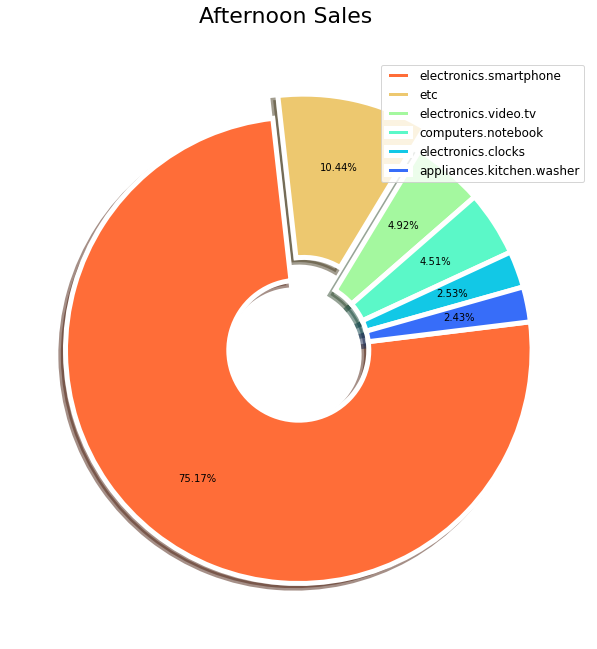

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
fig.suptitle('Afternoon Sales', fontsize=22)
fig.subplots_adjust(left=0.125, bottom=0., right=0.9, top=0.9, wspace=0.2, hspace=0.4)
sns.axes_style(style='darkgrid')

# 들어갈 라벨
labels=df_afternoon['category_code']

# 특수한 파이를 돌출
explode = [0, 0.1, 0, 0, 0, 0]

# 색설정 및 몇개 색이 필요한지 len값으로 설정
colors = sns.color_palette('rainbow_r',len(df_afternoon['category_code']))

# 하얀색 테두리 그리기
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

# price에 대한 파이나누기(소숫점 둘째점까지 표현)
plt.pie(df_afternoon['price'], autopct = "%1.2f%%", pctdistance=0.7,
startangle=7, counterclock=False, explode=explode, shadow=True, colors=colors, wedgeprops=wedgeprops)
plt.legend(labels, fontsize = 12, loc = 'upper right')
plt.show()

del df_afternoon

In [21]:
def afternoon_CVR(df = df_time) :
    df = df[df['category_code_0'] != 'missing']
    df = df[df['hour'] == 'afternoon'][['event_type_view', 'event_type_purchase', 'category_code', 'price']]
    df = df[['category_code', 'event_type_view', 'event_type_purchase']].groupby(['category_code']).sum().reset_index()[['category_code','event_type_view', 'event_type_purchase']]
    df['CVR(%)'] = df['event_type_purchase'] / df['event_type_view'] * 100
    df = df[['category_code', 'CVR(%)']]
    df = df.sort_values('CVR(%)', ascending=False).reset_index(drop = True)

    return df

In [22]:
df_afternoon_CVR = afternoon_CVR()
df_afternoon_CVR

,category_code,CVR(%)
0,electronics.smartphone,3.428280
1,electronics.audio.headphone,3.286151
2,kids.fmcg.diapers,3.113004
3,appliances.kitchen.microwave,2.366492
4,appliances.iron,2.319742
...,...,...
124,apparel.underwear,0.198061
125,apparel.shoes.slipons,0.176946
126,apparel.dress,0.100524
127,country_yard.furniture.bench,0.000000


In [23]:
def afternoon_CVR_sort(df = df_afternoon_CVR) :
    
    sales_top = [1,5,7,9,10]
    sales = df.index.values.tolist()
    diff = list(set(sales).difference(sales_top))

    aft_top5 = df[df.index.isin(sales_top)].sort_values(by=['CVR(%)'], ascending=False)
    aft_etc = df[df.index.isin(diff)]
    aft_etc['category_code'] = aft_etc['category_code'].apply(lambda x : 'etc')
    aft_etc = aft_etc.groupby(['category_code']).sum().reset_index()

    df = pd.concat([aft_top5, aft_etc])
    return df

In [24]:
df_afternoon_CVR_sort = afternoon_CVR_sort()
df_afternoon_CVR_sort

C:\Users\havea\AppData\Local\Temp/ipykernel_8620/3990688516.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aft_etc['category_code'] = aft_etc['category_code'].apply(lambda x : 'etc')


,category_code,CVR(%)
1,electronics.audio.headphone,3.286151
5,appliances.personal.scales,2.221612
7,medicine.tools.tonometer,2.128600
9,electronics.video.tv,2.009985
10,appliances.ironing_board,1.927938
0,etc,129.110628


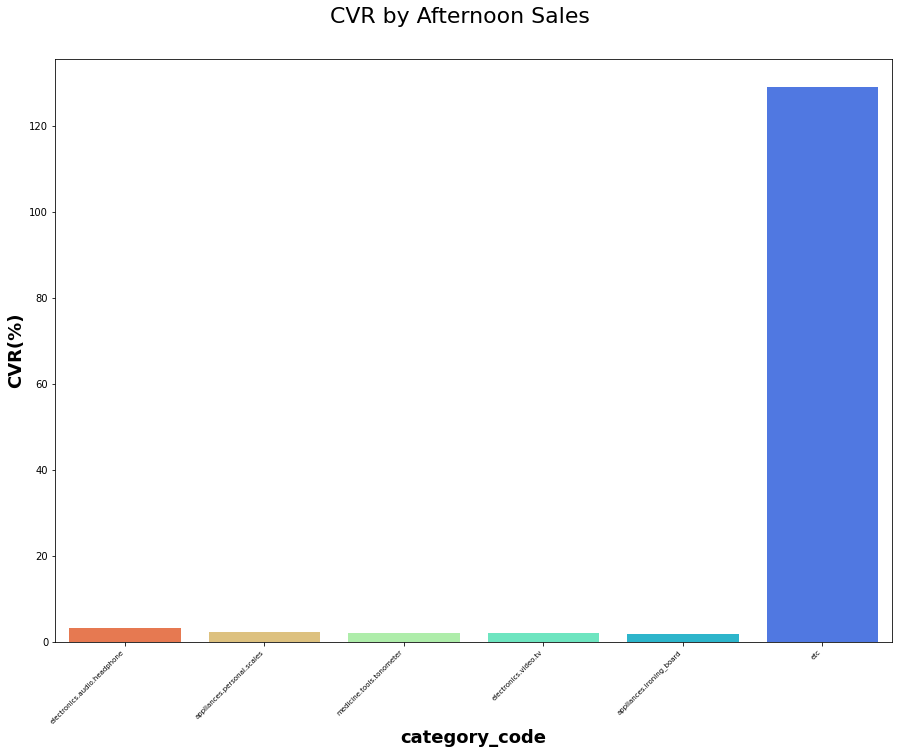

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
fig.suptitle('CVR by Afternoon Sales', fontsize=22)
fig.subplots_adjust(left=0.125, bottom=0., right=0.9, top=0.9, wspace=0.2, hspace=0.4)
sns.axes_style(style='darkgrid')

CVR_bar = sns.barplot(x='category_code', y= 'CVR(%)', data=df_afternoon_CVR_sort, palette='rainbow_r')
# CVR_bar.set(font_scale=1.8)
CVR_bar.set_xticklabels(CVR_bar.get_xticklabels(), rotation=45,
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-small'
                 )

plt.xlabel('category_code', fontsize = 18, fontweight = 'bold')
plt.ylabel('CVR(%)', fontsize = 18, fontweight = 'bold')
plt.show

del df_afternoon_CVR
del df_afternoon_CVR_sort

##### 2.2 Evening 시간대

In [6]:
def timezone_evening(df = df_time) :
    df = df[df['category_code_0'] != 'missing'] 
    df = df[df['hour'] == 'evening'][['event_type_view', 'event_type_purchase', 'category_code', 'price']]

    df_sale = df[df['event_type_purchase'] == 1].groupby(['category_code']).sum().reset_index()[['category_code', 'price']]
    df_sale = df_sale.sort_values('price', ascending=False)

    df_sale_top5 = df_sale[0:5]
    df_sale_etc = df_sale[6:]
    df_sale_etc['category_code'] = df_sale_etc['category_code'].apply(lambda x : 'etc')
    df_sale_etc = df_sale_etc.groupby(['category_code']).sum().reset_index()

    df = pd.concat([df_sale_top5, df_sale_etc]).sort_values(by=['price'], ascending=False)

    return df

In [7]:
df_evening = timezone_evening()
df_evening

C:\Users\havea\AppData\Local\Temp/ipykernel_7100/782239966.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sale_etc['category_code'] = df_sale_etc['category_code'].apply(lambda x : 'etc')


,category_code,price
93,electronics.smartphone,46135494.51
0,etc,7417625.66
97,electronics.video.tv,3196963.15
68,computers.notebook,2952114.15
92,electronics.clocks,1789906.79
46,appliances.kitchen.washer,1538841.41


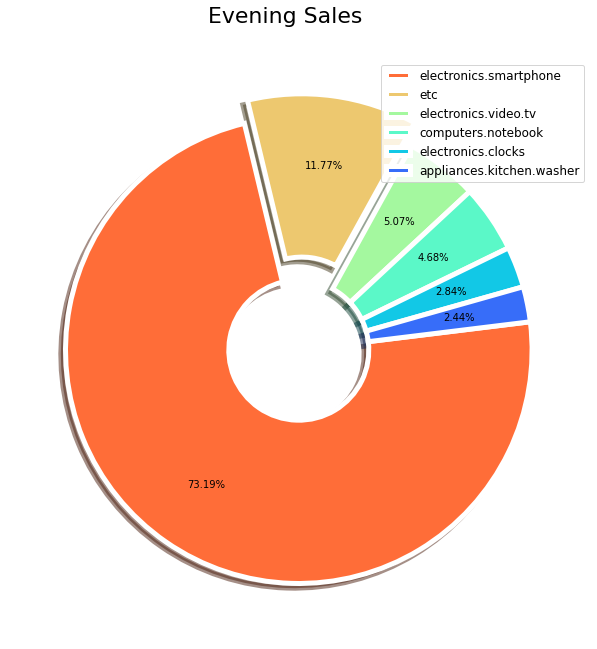

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
fig.suptitle('Evening Sales', fontsize=22)
fig.subplots_adjust(left=0.125, bottom=0., right=0.9, top=0.9, wspace=0.2, hspace=0.4)
sns.axes_style(style='darkgrid')

# 들어갈 라벨
labels=df_evening['category_code']

# 특수한 파이를 돌출
explode = [0, 0.1, 0, 0, 0, 0]

# 색설정 및 몇개 색이 필요한지 len값으로 설정
colors = sns.color_palette('rainbow_r',len(df_evening['category_code']))

# 하얀색 테두리 그리기
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

# price에 대한 파이나누기(소숫점 둘째점까지 표현)
plt.pie(df_evening['price'], autopct = "%1.2f%%", pctdistance=0.7,
startangle=7, counterclock=False, explode=explode, shadow=True, colors=colors, wedgeprops=wedgeprops)
plt.legend(labels, fontsize = 12, loc = 'upper right')
plt.show()

del df_evening

In [9]:
def evening_CVR(df = df_time) :
    df = df[df['category_code_0'] != 'missing']
    df = df[df['hour'] == 'evening'][['event_type_view', 'event_type_purchase', 'category_code', 'price']]
    df = df[['category_code', 'event_type_view', 'event_type_purchase']].groupby(['category_code']).sum().reset_index()[['category_code','event_type_view', 'event_type_purchase']]
    df['CVR(%)'] = df['event_type_purchase'] / df['event_type_view'] * 100
    df = df[['category_code', 'event_type_view', 'event_type_purchase', 'CVR(%)']]
    df = df.sort_values('CVR(%)', ascending=False).reset_index(drop = True)
    df = df[['category_code', 'event_type_view', 'event_type_purchase']]

    return df

In [10]:
df_evening_CVR = evening_CVR()
df_evening_CVR

,category_code,event_type_view,event_type_purchase
0,kids.fmcg.diapers,9267,200
1,electronics.audio.headphone,502109,10677
2,electronics.smartphone,5094449,100187
3,medicine.tools.tonometer,6559,114
4,appliances.personal.scales,29697,505
...,...,...,...
124,apparel.jacket,72,0
125,appliances.kitchen.fryer,11,0
126,construction.tools.screw,24,0
127,country_yard.furniture.hammok,678,0


In [11]:
def evening_CVR_sort(df = df_evening_CVR) :
    
    sales_top = [2,13,44,29,11]
    sales = df.index.values.tolist()
    diff = list(set(sales).difference(sales_top))

    eve_etc = df[df.index.isin(diff)]
    eve_etc['category_code'] = eve_etc['category_code'].apply(lambda x : 'etc')
    eve_etc = eve_etc.groupby(['category_code']).sum().reset_index()
    eve_etc['CVR(%)'] = eve_etc['event_type_purchase'] / eve_etc['event_type_view'] * 100

    eve_top5 = df[df.index.isin(sales_top)]
    eve_top5['CVR(%)'] = eve_top5['event_type_purchase'] / eve_top5['event_type_view'] * 100

    # eve_top5 = df[df.index.isin(sales_top)].sort_values(by=['CVR(%)'], ascending=False)
    # eve_etc = df[df.index.isin(diff)]
    # eve_etc['category_code'] = eve_etc['category_code'].apply(lambda x : 'etc')
    # eve_etc = eve_etc.groupby(['category_code']).sum().reset_index()
    # eve_etc = eve_etc['CVR(%)'] = eve_etc['event_type_purchase'] / eve_etc['event_type_view'] * 100

    df = pd.concat([eve_top5, eve_etc])
    return df

In [12]:
df_evening_CVR_sort = evening_CVR_sort()
df_evening_CVR_sort

C:\Users\havea\AppData\Local\Temp/ipykernel_7100/3485960996.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eve_etc['category_code'] = eve_etc['category_code'].apply(lambda x : 'etc')
C:\Users\havea\AppData\Local\Temp/ipykernel_7100/3485960996.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eve_top5['CVR(%)'] = eve_top5['event_type_purchase'] / eve_top5['event_type_view'] * 100


,category_code,event_type_view,event_type_purchase,CVR(%)
2,electronics.smartphone,5094449,100187,1.966591
11,appliances.kitchen.washer,415419,5234,1.259933
13,electronics.video.tv,635087,7927,1.248175
29,electronics.clocks,707038,6767,0.957091
44,computers.notebook,630538,5068,0.803758
0,etc,6779539,59133,0.872227


NameError: name 'df_afternoon_CVR_sort' is not defined

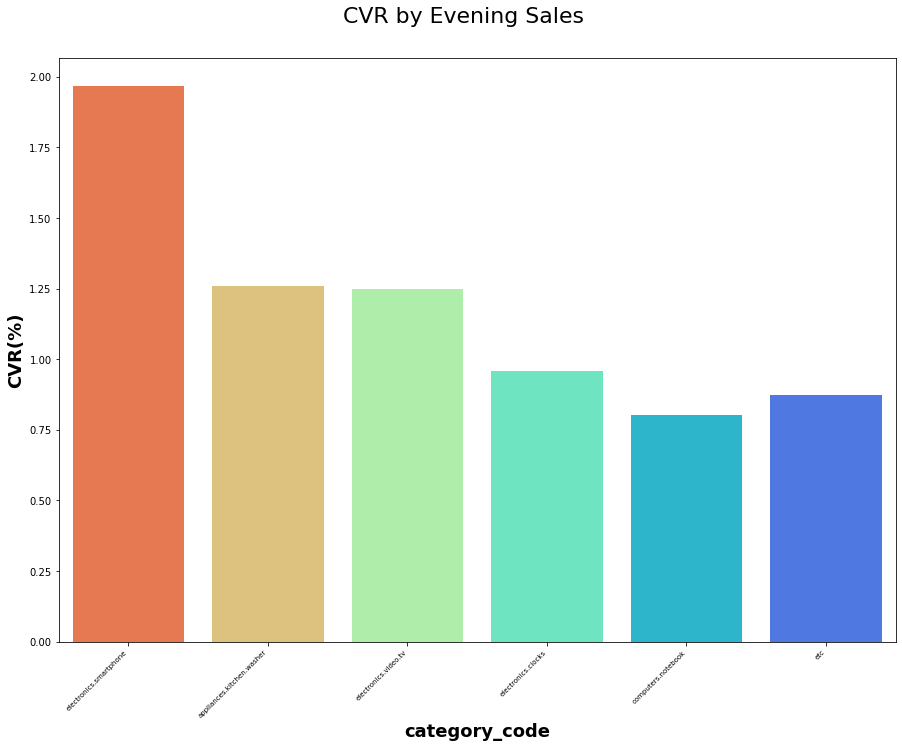

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
fig.suptitle('CVR by Evening Sales', fontsize=22)
fig.subplots_adjust(left=0.125, bottom=0., right=0.9, top=0.9, wspace=0.2, hspace=0.4)
sns.axes_style(style='darkgrid')

CVR_bar = sns.barplot(x='category_code', y= 'CVR(%)', data=df_evening_CVR_sort, palette='rainbow_r')
# CVR_bar.set(font_scale=1.8)
CVR_bar.set_xticklabels(CVR_bar.get_xticklabels(), rotation=45,
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-small'
                 )

plt.xlabel('category_code', fontsize = 18, fontweight = 'bold')
plt.ylabel('CVR(%)', fontsize = 18, fontweight = 'bold')
plt.show